This is an adapted version of the two notebooks made available by Park on his Github.

 FromPark’s github I download two notebooks representation analysis.ipynb and self-attention analysis.ipynb
 and combine them into one which is available on the above-shown link. I delete redundant download state
ments as well as the settings that invite the user to populate model parameters since I want to control that
 directly in the code. I only work with MoCo rather than SimMiM. 

In [ ]:
%%capture --no-stderr
from google.colab import drive
drive.mount("/content/drive")
import os
###Import pickle since I will need it below
import pickle
os.chdir('/content/drive/MyDrive/Colab Notebooks/ATDL/HA3')
import sys
!pip3 install timm==0.5.4
!pip3 install matplotlib==3.7.1
####!pip3 install scikit-learn==1.2.2
import sklearn
!pip3 install fastai==2.7.12
!pip3 install einops==0.6.0
!pip3 install gdown==4.7.1
!pip3 install yacs==0.1.8
!git clone https://github.com/naver-ai/cl-vs-mim.git
import torch
# check gpu env
print(f"Torch: {torch.__version__} \n" +
      f"Availability: {torch.cuda.is_available()}")
assert torch.cuda.is_available() == True, "The GPU is turned off. To turn it on, navigate to: Runtime > Change Runtime Type."
print(f"Number: {torch.cuda.device_count()} \n" +
      f"Current device: {torch.cuda.current_device()} \n" +
      f"First device: {torch.cuda.device(0)} \n" +
      f"Device name: {torch.cuda.get_device_name(0)}")


In [ ]:
import os
import math
import numpy as np
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import timm.data.transforms_factory as tff
from fastai.data.external import untar_data, URLs

os.chdir('/content/drive/MyDrive/Colab Notebooks/ATDL/HA3/cl-vs-mim')
from utils import subsample
os.chdir('/content/drive/MyDrive/Colab Notebooks/ATDL/HA3')


In [ ]:
imagenet_path = untar_data(URLs.IMAGENETTE_160)

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

transform_test = tff.transforms_imagenet_eval(
    img_size=224, mean=imagenet_mean, std=imagenet_std,
)

test_dir = os.path.join(imagenet_path, 'val')
dataset_test = datasets.ImageFolder(test_dir, transform_test)
dataset_test = torch.utils.data.Subset(
    dataset_test,
    subsample(dataset_test, ratio=math.pow(2,-6))  # use a subsampled batch
)

dataset_test = DataLoader(
    dataset_test,
    num_workers=1,
    batch_size=16,
)

MoCo-weights can be accessed via the url as programmed by Park.

In [ ]:
# MoCo
print(os.getcwd() )
import torch
os.chdir('/content/drive/MyDrive/Colab Notebooks/ATDL/HA3/cl-vs-mim')
import models.moco as moco
from models.moco import load_state_dict
from utils import download
os.chdir('/content/drive/MyDrive/Colab Notebooks/ATDL/HA3')

name = "moco_vit_b"  #@param {type:"string"}
path = "checkpoints/moco_vit_b.pt"  #@param {type:"string"}
url = "https://dl.fbaipublicfiles.com/moco-v3/vit-b-300ep/vit-b-300ep.pth.tar"

download(url, path, force=False)  # download checkpoints

model = moco.vit_base()
model = model.cuda()
model = model.eval()

state_dict = load_state_dict(path)
_ = model.load_state_dict(state_dict, strict=False)
model_moco = model

/content/drive/MyDrive/Colab Notebooks/ATDL/HA2_2


/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


I delete the menu bar since I only work with MoCo. I save the figure to the relevant subdirectory.

<>:67: SyntaxWarning: invalid escape sequence '\D'
<>:67: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-2889208463.py:67: SyntaxWarning: invalid escape sequence '\D'
  ax.set_ylabel("$\Delta$ Log amplitude")


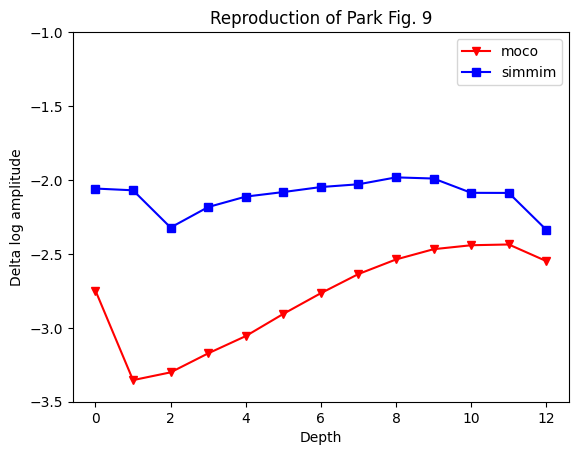

In [ ]:
# build off the implementation of https://github.com/xxxnell/how-do-vits-work
import matplotlib.pyplot as plt
from einops import rearrange, reduce, repeat
from timm.utils import AverageMeter

def fourier(x):
    """2D Fourier transform"""
    f = torch.fft.fft2(x)
    f = f.abs() + 1e-6
    f = f.log()
    return f

def shift(x):
    """shift Fourier transformed feature map"""
    b, c, h, w = x.shape
    return torch.roll(x, shifts=(int(h/2), int(w/2)), dims=(2, 3))

def get_fourier_latents(latents):
    """Fourier transform feature maps"""
    fourier_latents = []
    for latent in latents:  # `latents` is a list of hidden feature maps in latent spaces
        latent = latent.cpu()
        b, n, c = latent.shape
        h, w = int(math.sqrt(n)), int(math.sqrt(n))
        latent = rearrange(latent, "b (h w) c -> b c h w", h=h, w=w)

        latent = fourier(latent)
        latent = shift(latent).mean(dim=(0, 1))
        latent = latent.diag()[int(h/2):]  # only use the half-diagonal components
        latent = latent - latent[0]  # visualize 'relative' log amplitudes
                                     # (i.e., low-freq amp - high freq amp)
        fourier_latents.append(latent)

    return fourier_latents

os.chdir('/content/drive/MyDrive/Colab Notebooks/ATDL/HA3/Fig9files')
####Instead of the menu bar, perform both options
res = []
for model_option in ["moco"]:
  if model_option == "moco":
      model = model_moco
  elif model_option == "simmim":
      model = model_simmim
  else:
      raise Exception("Invalid option: ", model_option)

  fourier_latents = AverageMeter()
  for i, (xs, ys) in enumerate(dataset_test):
      with torch.no_grad():
          xs = xs.cuda()
          _, zs, _, _ = model(xs)
          zs = zs[:-1]

      latents = [z[:,1:,:] for z in zs]
      _fourier_latents = torch.stack(get_fourier_latents(latents))
      fourier_latents.update(_fourier_latents)

      if i > -1:
          break

  namo = "rep "+model_option
  fig, ax = plt.subplots(1, 1, figsize=(4.2, 4), dpi=150)
  fourier_latents = fourier_latents.avg
  ax.plot(range(13), fourier_latents[:,-1][::2], marker="o")
  res.append(list(fourier_latents[:,-1][::2]))
  ax.set_xlabel("Depth")
  ax.set_ylabel("$\Delta$ Log amplitude")
  ax.set_ylim(top=-1.5, bottom=-3.5)
  ax.set_title(namo)
  fig.savefig(namo+".jpg")
  plt.show()
  plt.close()

plt.plot(range(13), res[0], label="moco", color="red", marker='v')
plt.legend()
plt.title("Reproduction of Park Fig. 9")
plt.ylabel("Delta log amplitude")
plt.xlabel("Depth")
plt.ylim([-3.5,-1])
fig = plt.gcf()
fig.savefig("fig9.jpg")
plt.show()
plt.close()
os.chdir('/content/drive/MyDrive/Colab Notebooks/ATDL/HA2_2')

The below is from the Self-Attention Analysis-notebook by Park.

Replicate Figure 2 in Park on an image available in Imagenette. There are 8 heads in total, zero-indexed.

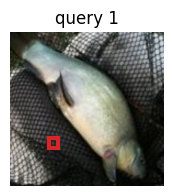

moco query 1 d=1 b=4


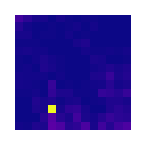

moco query 1 d=4 b=4


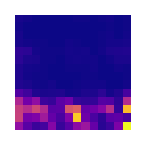

moco query 1 d=11 b=4


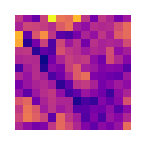

simmim query 1 d=1 b=4


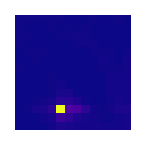

simmim query 1 d=4 b=4


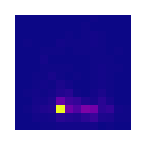

simmim query 1 d=11 b=4


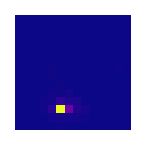

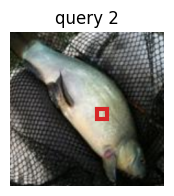

moco query 2 d=1 b=4


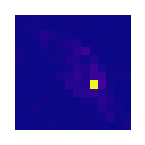

moco query 2 d=4 b=4


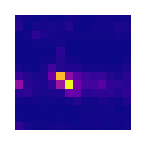

moco query 2 d=11 b=4


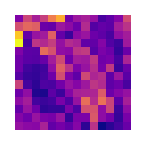

simmim query 2 d=1 b=4


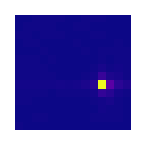

simmim query 2 d=4 b=4


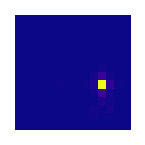

simmim query 2 d=11 b=4


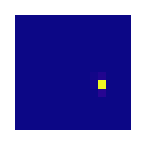

In [ ]:
def mark_token(namo, ax, xs, batch, i, j, color='tab:red'):
    fig, ax = plt.subplots(1, 1, figsize=(2, 2), dpi=100)
    import matplotlib.patches as patches
    from einops import rearrange, reduce, repeat
    from utils import restore

    ax.imshow(rearrange(restore(xs.cpu())[batch], 'c h w -> h w c'))
    ax.set_axis_off()

    # create a rectangle patch to visualize the query token
    rect = patches.Rectangle((14 * i, 14 * j), 14, 14, linewidth=3, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    plt.title(namo)
    plt.show()
    fig.savefig(namo+".jpg")
    plt.close()

def visualize_attn(fig, ax, namo, attns, batch, i, j, depth, head):
    """
    ax: matplotlib axes
    xs: batch
    batch, i, j: batch coords
    attns, depth, head:
    """
    attn_list = [list(attn[batch].cpu()) if attn is not None else None for attn in attns]
    attn = torch.stack(attn_list[depth])
    attn = attn[head]  # take head-th head
    attn = attn[1:,1:]  # drop cls token
    attn = attn / attn.sum(dim=-1, keepdim=True)  # normalize
    attn = attn[j * 14 + i]
    attn = attn.reshape([14, 14])
    fig, ax = plt.subplots(1, 1, figsize=(1, 1), dpi=150)

    fig.set_title(namo)
    ax.imshow(attn, cmap="plasma", )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_axis_off()
    fig.savefig(namo+".jpg")
    plt.show()
    plt.close()
    return attn


####This visualization demonstrates that the self-attentions of CL (MoCo) generally captures global relationships and objects. However, they tend to produce homogeneous attention maps for all query tokens and heads, particularly when compared to MIM. In contrast, the self-attentions of MIM (SimMIM) primarily focus on localized areas.

os.chdir('/content/drive/MyDrive/Colab Notebooks/ATDL/HA3/blhfiles')
for filename in os.listdir():
  os.remove(filename)
class Image:
    def __init__(self):
        self.heads = []

class Head:
    def __init__(self):
        self.layers = []

images = []

for batch in range(16):
    img = Image()
    for head in range(8):
        hd = Head()
        tuplo = (4,11)
        coord_x, coord_y = tuplo
        token_name = "Image"+str(batch)
        mark_token(token_name, ax, xs, batch=batch, i=coord_x, j=coord_y, color='tab:red')
        model = model_moco
        for d_index in range (3):
            depth = [1, 4, 11][d_index]
            namo = "b"+str(batch)+"h"+str(head)+"d"+str(depth)
            print(namo)
            xs, ys = next(iter(dataset_test))
            with torch.no_grad():
                xs = xs.cuda()
                _, _, attns, _ = model(xs)
            data = visualize_attn(fig, ax, namo, attns, batch=batch, i=coord_x, j=coord_y, depth=depth, head=head)
            print(type(data), end=" ")
            print(data.shape, end=" ")
            hd.layers.append(data)
        img.heads.append(hd)
    images.append(img)
    print("\n")
        
pickle.dump(images, "images.pickle")
os.chdir('/content/drive/MyDrive/Colab Notebooks/ATDL/HA3')

To compare by head, perform the above but for all 8 heads, save figures to relevant subdirectory.

head = 0 d=1


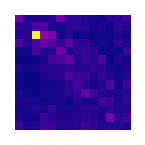

head = 0 d=4


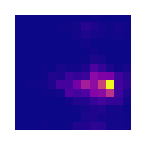

head = 0 d=11


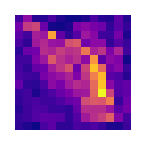

head = 1 d=1


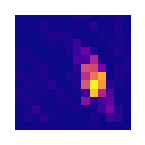

head = 1 d=4


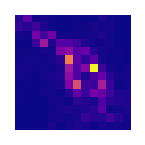

head = 1 d=11


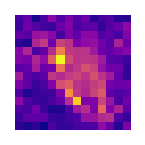

head = 2 d=1


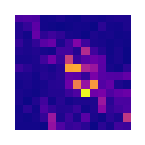

head = 2 d=4


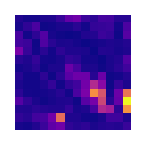

head = 2 d=11


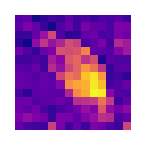

head = 3 d=1


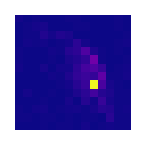

head = 3 d=4


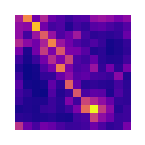

head = 3 d=11


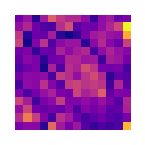

head = 4 d=1


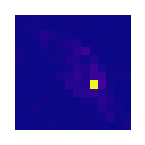

head = 4 d=4


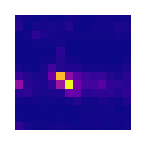

head = 4 d=11


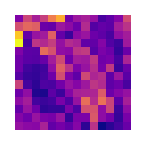

head = 5 d=1


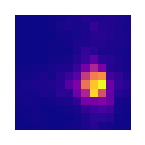

head = 5 d=4


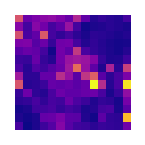

head = 5 d=11


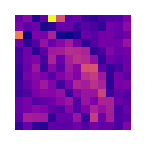

head = 6 d=1


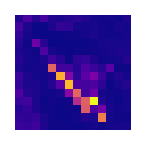

head = 6 d=4


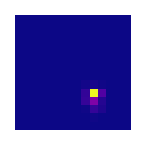

head = 6 d=11


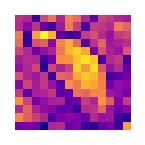

head = 7 d=1


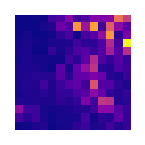

head = 7 d=4


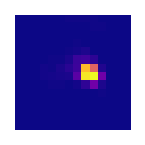

head = 7 d=11


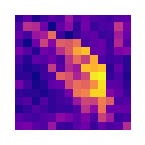

In [ ]:

os.chdir('/content/drive/MyDrive/Colab Notebooks/ATDL/HA3/Headfiles')
for filename in os.listdir():
  os.remove(filename)
batch = 4
coord_x, coord_y = [(4,11), (9,8)][1]
model_option = "moco"
model = model_moco
for head in range(8):
  for depth in [1, 4, 11]:

    namo = "head = "+str(head)+" d="+str(depth)
    print(namo)

    xs, ys = next(iter(dataset_test))
    with torch.no_grad():
        xs = xs.cuda()
        _, _, attns, _ = model(xs)


    visualize_attn(fig, ax, namo, attns, batch=batch, i=coord_x, j=coord_y, depth=depth, head=head)

os.chdir('/content/drive/MyDrive/Colab Notebooks/ATDL/HA3')